In [3]:
# Import packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools
import numpy as np
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from fbprophet import Prophet


# Preferred settings
warnings.simplefilter("ignore")


In [4]:
# Import saved data
df_TS = pd.read_csv('Data/df_TS.csv')

# Set date column to datetime object
df_TS['Date'] = pd.to_datetime(df_TS['Date'])

# Set date column as index
df_TS.set_index('Date', inplace=True)

# Prepare Data

In [5]:
# Only use pre-COVID data for time series modeling
df_TS_preCOV = df_TS.loc[:'2020-3-13']


In [6]:
# Create df of only Brooklyn data, remove all columns other than accident counts 
df_prophet = df_TS_preCOV.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Man', 'Accidents_Qns', 'Accidents_SI',
                               'Accidents_Total','Season','Day of Week', 'Weekend','Holiday'])

# Rename columns to [ds,y] per fb prophet specifications
df_prophet['ds'] = df_prophet.index
df_prophet.rename(columns={'Accidents_Bkln': 'y'},inplace=True)


In [7]:
df_prophet.head()

,y,ds
Date,,
2012-07-01,140.0,2012-07-01
2012-07-02,146.0,2012-07-02
2012-07-03,176.0,2012-07-03
2012-07-04,104.0,2012-07-04
2012-07-05,158.0,2012-07-05


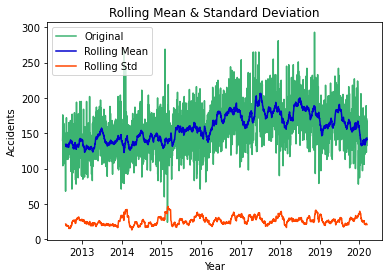

Test Statistic                   -3.239439
p-value                           0.017812
#Lags Used                       27.000000
Number of Observations Used    2783.000000
dtype: float64

In [11]:
# Visualize data, including 30-day rolling mean and standard deviation

roll_mean = df_prophet['y'].rolling(window=30, center=False).mean()
roll_std = df_prophet['y'].rolling(window=30, center=False).std()

plt.plot(df_prophet['y'],color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_prophet['y'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above visualization and Dickey-Fuller p-value, we see that this data is stationary. We will therefore not perform differencing, a log transformation, or any other transformation on the data before fitting a model.

# Facebook Prophet Modeling

## Fit Model and Generate Predictions

In [12]:
# Fit model to data
model = Prophet(interval_width=0.95)
model.fit(df_prophet)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
# Make predictions 658 days into the future--ie until 12/31/21
# Create future dates
future_dates = model.make_future_dataframe(periods=658, freq='D')

# Generate predictions
forecast = model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-07-01,133.741458,69.902254,156.529260,133.741458,133.741458,-16.993078,-16.993078,-16.993078,-25.742719,-25.742719,-25.742719,8.749641,8.749641,8.749641,0.0,0.0,0.0,116.748380
1,2012-07-02,133.750829,101.334339,190.901073,133.750829,133.750829,13.883135,13.883135,13.883135,6.607448,6.607448,6.607448,7.275687,7.275687,7.275687,0.0,0.0,0.0,147.633964
2,2012-07-03,133.760200,100.312437,191.320455,133.760200,133.760200,13.682718,13.682718,13.682718,7.830415,7.830415,7.830415,5.852303,5.852303,5.852303,0.0,0.0,0.0,147.442918
3,2012-07-04,133.769571,100.938102,184.689447,133.769571,133.769571,8.644710,8.644710,8.644710,4.139979,4.139979,4.139979,4.504731,4.504731,4.504731,0.0,0.0,0.0,142.414281
4,2012-07-05,133.778942,100.634196,190.267638,133.778942,133.778942,11.831861,11.831861,11.831861,8.575867,8.575867,8.575867,3.255995,3.255995,3.255995,0.0,0.0,0.0,145.610803


## Visualize Model

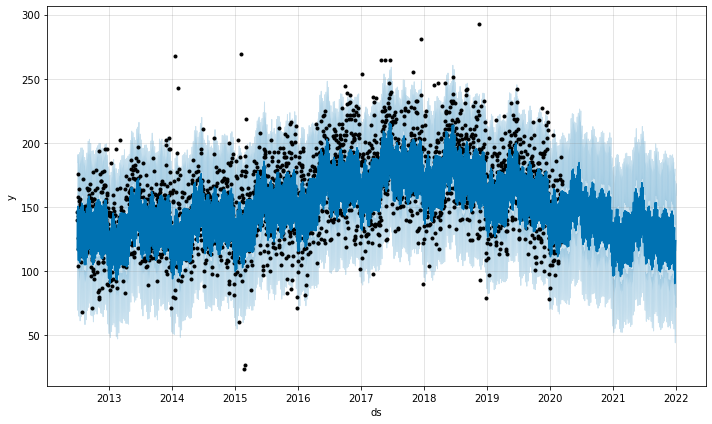

In [14]:
# Subset useful columns from forecast
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot forecast
model.plot(forecast,uncertainty=True)
plt.show()

KeyError: 'trend'

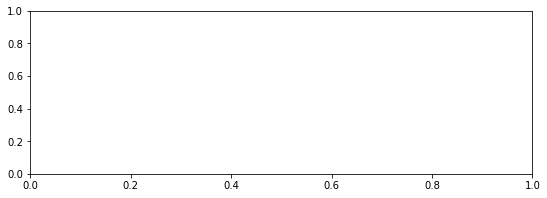

In [16]:
# Plot model components
model.plot_components(forecast)
plt.show()

## Assess Model

In [ ]:
# Assess model using RMSE to compare to our working ARIMA model

# ARIMA Models

## Baseline Model: ARIMA with no Exogenous Variables

**ACF, PACF**

In [ ]:
# ACF
plot_acf(df_bkln['Accidents_Bkln'], alpha=.05);

# PACF
plot_pacf(df_bkln['Accidents_Bkln'], alpha=.05, lags=20);

Based on the above ACF and PACF, when instantiating an ARIMA model, we would expect a relatively large number of MA terms due to the larger number of significant ACF points and a relatively small number of AR terms due to the small number of significant PACF points.

**Train-Test Split**

In [ ]:
# Determine split point for 90%/10% train-test split
split_point = int(len(df_bkln) * 0.9)
df_bkln.iloc[split_point]

In [ ]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_bkln.index
y = df_bkln['Accidents_Bkln']

train = df_bkln.loc[:'2019-06-06']
test = df_bkln.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_Bkln'] , test['Accidents_Bkln']

**Grid Search**

In [ ]:
# Determine best parameters for ARIMA model

# Define the p, d, and q parameters to take any value between 0 and 4
p = d = q = range(0,4)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq parameters calculated to see corresponding AIC scores
ans_ARIMA = []
for comb in pdq:
    try:
        mod = ARIMA(y_train, order=comb)
        output = mod.fit()
        ans_ARIMA.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

In [ ]:
# Find parameters with minimal AIC value
df_AIC = pd.DataFrame(ans_ARIMA, columns=['pdq', 'aic'])
df_AIC.sort_values(by='aic', ascending=True, inplace=True)
df_AIC[:10]

**Narrowing Down Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [ ]:
for pdq in df_AIC['pdq'][:10]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())


From the above, we see that none of these parameters have significant p-values. We will now look at the next 10 lowest AIC scores in search of our best ARIMA model.

In [ ]:
for pdq in df_AIC['pdq'][10:20]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())

From the above, we see that parameters (1,0,2) and (3,0,1) and significant p-values. We will look at the next 5 lowest AIC values to see if any others are significant so we can compare their RMSEs.

In [ ]:
for pdq in df_AIC['pdq'][20:25]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())

From the above, we see that parameters (2,0,1) and (1,0,1) are also significant. We will compare RMSE values for these parameters as well as (1,0,2) and (3,0,1).

**Determine Best ARIMA Model**

In [ ]:
# Create RMSE function
def RMSE(pred):
    return np.sqrt(((pred-y_test)**2).mean())

# For loop to apply RMSE function to significant parameters
for pdq in [(2,0,1),(1,0,1),(1,0,2),(3,0,1)]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', dynamic=False)
    print(pdq,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)

Through a combination of RMSE and AIC, an ARIMA model with parameters (1,0,1) is our best baseline model. We will now compare this baseline model to other types of time series models.

In [ ]:
# Define baseline model for future comparison
base = ARIMA(y_train[:-1], order=(1,0,1))
base_fit = base.fit()
base_pred = base_fit.predict(start='2019-06-06', end='2020-03-13', dynamic=False)
base_RMSE = RMSE(base_pred)
base_AIC = base_fit.aic

print('Baseline model RMSE: ', base_RMSE)
print('Baseline model RMSE adj for range: ',
      base_RMSE/(df_bkln['Accidents_Bkln'].max()-df_bkln['Accidents_Bkln'].min()))
print('Baseline model AIC: ', base_AIC)




## Model #2: Introducing Exogenous Variables: ARIMAX Model

Now that we have our baseline ARIMA model, we will try incorporating exogenous variables with an ARIMAX model.

**Clean Data for ARIMAX Model**

In [ ]:
# Turn exogenous variables into integers so they work in the model
# Season
df_bkln['Season'] = np.where(df_bkln['Season']=='Fall', 1, df_bkln['Season'])
df_bkln['Season'] = np.where(df_bkln['Season']=='Winter', 2, df_bkln['Season'])
df_bkln['Season'] = np.where(df_bkln['Season']=='Spring', 3, df_bkln['Season'])
df_bkln['Season'] = np.where(df_bkln['Season']=='Summer', 4, df_bkln['Season'])

# Day of Week
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Sunday', 1, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Monday', 2, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Tuesday', 3, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Wednesday', 4, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Thursday', 5, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Friday', 6, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Saturday', 7, df_bkln['Day of Week'])

# Weekend (these turned into strings when the data was imported from the csv)
df_bkln['Weekend'] = np.where(df_bkln['Weekend']=='0', 0, df_bkln['Weekend'])
df_bkln['Weekend'] = np.where(df_bkln['Weekend']=='1', 1, df_bkln['Weekend'])

# Holiday (these turned into strings when the data was imported from the csv)
df_bkln['Holiday'] = np.where(df_bkln['Holiday']=='0', 0, df_bkln['Holiday'])
df_bkln['Holiday'] = np.where(df_bkln['Holiday']=='1', 1, df_bkln['Holiday'])



**Redefine Train-Test Split with Cleaned Data**

In [ ]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_bkln.index
y = df_bkln['Accidents_Bkln']

train = df_bkln.loc[:'2019-06-06']
test = df_bkln.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_Bkln'] , test['Accidents_Bkln']

In [ ]:
# Make list of lists of exogenous data to be used in the model
list_of_lists = []
for column in list(train.iloc[:,1:].columns):
    list_of_lists.append(list(train[column]))
    
exog=np.column_stack(list_of_lists)


**Grid Search**

In [ ]:
# Determine best parameters for ARIMAX model

# Define the p, d, and q parameters to take any value between 0 and 4
p = d = q = range(0,4)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq parameters calculated to see corresponding AIC scores
ans_ARIMAX2 = []
for comb in pdq:
    try:
        mod = sm.tsa.ARIMA(endog=y_train,
                           exog=exog,
                           order=comb)
        output = mod.fit()
        ans_ARIMAX2.append([comb, output.aic])
        print('ARIMAX {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

In [ ]:
# Find parameters with minimal AIC value
df_AIC = pd.DataFrame(ans_ARIMAX2, columns=['pdq', 'aic'])
df_AIC.sort_values(by='aic', ascending=True, inplace=True)
df_AIC[:10]

**Determining Best Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [ ]:
for pdq in df_AIC['pdq'][:10]:
    mod = sm.tsa.ARIMA(endog=y_train,
                       exog=exog,
                       order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())
    

We don't see any significant p values above, so will look at the next 10 lowest AIC scores.

In [ ]:
for pdq in df_AIC['pdq'][10:20]:
    mod = sm.tsa.ARIMA(endog=y_train,
                       exog=exog,
                       order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())
    

From the above, we see that the following parameters have significant p values:

(1,1,3)

(1,1,2)

(2,1,1)

(1,1,1)

We will observe RMSE and AIC values for these to determine our best working model.

In [ ]:
# For loop to apply RMSE function to significant parameters
for (pdq) in [(1,1,3),(1,1,2),(2,1,1),(1,1,1)]:
    mod = sm.tsa.ARIMA(endog=y_train,
                           exog=exog,
                           order=pdq)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:], dynamic=False)
    mod_RMSE = RMSE(mod_pred)
    mod_AIC = mod_fit.aic
    print(pdq,' RMSE: ', mod_RMSE)
    print(pdq,' AIC: ', mod_AIC)  
    

All of the above models have very similar RMSEs. We will therefore choose our best model based on AIC, which puts parameters (1,1,3) slightly ahead of the others. We will define this as our ARIMAX model and compare it to our baseline ARIMA model.

In [ ]:
# Define ARIMAX model
ARIMAX = sm.tsa.ARIMA(endog=y_train, exog=exog, order=(1,1,3))
ARIMAX_fit = ARIMAX.fit()
ARIMAX_pred = ARIMAX_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:], dynamic=False)
ARIMAX_RMSE = RMSE(ARIMAX_pred)
ARIMAX_AIC = ARIMAX_fit.aic

# Compare ARIMA and ARIMAX model RMSEs and AICs

print('ARIMA model RMSE: ', base_RMSE)
print('ARIMA model AIC: ', base_AIC)

print('ARIMAX model RMSE: ', ARIMAX_RMSE)
print('ARIMAX model AIC: ', ARIMAX_AIC)



We see from the above that though our baseline model has a worse AIC score, it performs significantly better with RMSE. Since RMSE is what tells us more clearly how far off our predictions are, we will consider this the better model.

## Model #3: Introducing Seasonality: SARIMA Model

Or data is seasonal, so we would expect a SARIMA model to produce better results than our baseline ARIMA one.

**Resample Weekly Data**

Since data is seasonal by year, our period value would ordinarily be 365 observations. This is too large for a SARIMA model, so will create a df with weekly data and instead use a period value of 52.

In [ ]:
# Create df of weekly data
df_bkln_wk = df_bkln.resample('W')
df_bkln_wk_mean = df_bkln_wk.mean()


In [ ]:
# When we introduce exogenous data, the weekend column won't be valuable--remove it
df_bkln_wk_mean.drop(columns=['Weekend'], inplace=True)

# Change holiday column to be a 1 if there is any holiday that week,
# ie if the value is greater than 0
df_bkln_wk_mean['Holiday'] = np.where(df_bkln_wk_mean['Holiday']>0, 1, 0)

# Add in Season
df_bkln_wk_mean['Season'] = 0

def season(month,season):
    df_bkln_wk_mean['Season'] = np.where((df_bkln_wk_mean.index.month==month),
                                         season,df_bkln_wk_mean['Season'])

for month in range (1,4):
    season(month,2)
    
for month in range (4,7):
    season(month,3)
    
for month in range (7,10):
    season(month,4)

for month in range (10,13):
    season(month,1)

# Holiday
df_bkln_wk_mean['Holiday'] = np.where(df_bkln_wk_mean['Holiday']=='0',
                                      0, df_bkln_wk_mean['Holiday'])
df_bkln_wk_mean['Holiday'] = np.where(df_bkln_wk_mean['Holiday']=='1',
                                      1, df_bkln_wk_mean['Holiday'])

# Observe new df head
df_bkln_wk_mean.head()

In [ ]:
# Plot weekly data compared to daily
plt.plot(df_bkln['Accidents_Bkln'],color='mediumseagreen', label='Original')
plt.plot(df_bkln_wk_mean['Accidents_Bkln'], color='mediumblue', label='Weekly Mean')
plt.legend(loc='best')
plt.title('Weekly Mean, Brooklyn')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_bkln_wk_mean['Accidents_Bkln'][:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above Dickey-Fuller p-value, this data is not stationary. We will difference this data to attempt stationarity.

**Differencing**

In [ ]:
# Difference data
diff = df_bkln_wk_mean['Accidents_Bkln'].diff()

# Plot differenced data
plt.plot(diff, color='palevioletred', label='Differenced Rolling Weekly Mean')
plt.title('Differenced Weekly Mean, Brooklyn')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(diff[1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Differencing once achieved stationarity, so we would expect our SARIMA model to have a d value of at least 1.

**ACF, PACF for Weekly Data**

In [ ]:
# ACF for weekly data
plot_acf(df_bkln_wk_mean['Accidents_Bkln'], alpha=.05);

# PACF for weekly data
plot_pacf(df_bkln_wk_mean['Accidents_Bkln'], alpha=.05, lags=20);

**Redo Train-Test Split for Weekly Data**

In [ ]:
# Determine split point for 90%/10% train-test split
split_point = int(len(df_bkln_wk_mean) * 0.9)
df_bkln_wk_mean.iloc[split_point]

In [ ]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_bkln_wk_mean.index
y = df_bkln_wk_mean['Accidents_Bkln']

train = df_bkln_wk_mean.loc[:'2019-06-06']
test = df_bkln_wk_mean.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_Bkln'] , test['Accidents_Bkln']

**Grid Search for SARIMA Model**

In [ ]:
# Determine best parameters for SARIMA model

# Define the p, d, and q parameters to take any value between 0 and 2
# Using smaller range due to many combinations
p = d = q = range(0,2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d, q triplets
# Choose s value of 52 because data is now weekly and a cycle is one year

pdqs = [(x[0],x[1],x[2], 52) for x in pdq]

# Run a grid search with pdq parameters calculated to see corresponding AIC scores
ans_SARIMA = []
for comb in pdq:
    for combs in tqdm_notebook(pdqs):
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans_SARIMA.append([comb, combs, output.aic])
            print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find parameters with minimal AIC value
SARIMA_AIC = pd.DataFrame(ans_SARIMA, columns=['pdq', 'pdqs', 'aic'])
SARIMA_AIC.sort_values(by='aic', ascending=True, inplace=True)
SARIMA_AIC[:10]

**Narrowing Down Parameter Values**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [ ]:
for index,row in SARIMA_AIC[:10].iterrows():
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    order=SARIMA_AIC['pdq'][index],
                                    seasonal_order=SARIMA_AIC['pdqs'][index],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    mod_fit = mod.fit()
    print(mod_fit.summary())


Based on the above, we see that the following parameters yield significant p-values:

(0,1,1)x(0,1,1,52)

(1,0,1)x(0,1,1,52)

(0,1,1)x(1,1,0,52)

(1,0,1)x(1,1,0,52)

We wil observe RMSE and AIC values for these parameters to determine our best working model.

In [ ]:
# For loop to apply RMSE function to significant parameters
for (pdq,pdqs) in [((0,1,1),(0,1,1,52)),((1,0,1),(0,1,1,52)),((0,1,1),(1,1,0,52)),
                 ((1,0,1),(1,1,0,52))]:
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13',dynamic=False)
    print(pdq, 'x', pdqs,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)
    

Based on its best RMSE value and only slightly worse AIC value, we see that the thrid option gives us our best SARIMA model. We will define this as our SARIMA model and compare it to our baseline ARIMA model.

In order to compare RMSEs between daily and weekly data, we will divide RMSEs by the range of the number of accidents in each dataset. A smaller RMSE-to-range ratio will tell us which is our better RMSE. These will be labeled "Adjusted RMSE".

In [ ]:
SARIMA = sm.tsa.statespace.SARIMAX(y_train,
                                   order=(0,1,1),
                                   seasonal_order=(1,1,0,52),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
SARIMA_fit = SARIMA.fit()
SARIMA_pred = SARIMA_fit.predict(start='2019-06-06', end='2020-03-13',dynamic=False)
print('SARIMA RMSE: ', RMSE(SARIMA_pred))
print('Adjusted SARIMA RMSE: ',
      RMSE(SARIMA_pred)/(df_bkln_wk_mean['Accidents_Bkln'].max()-df_bkln_wk_mean['Accidents_Bkln'].min()))
print('SARIMA AIC: ', SARIMA_fit.aic)

print('ARIMA RMSE: ', base_RMSE)
print('Adjusted ARIMA RMSE: ',
      base_RMSE/(df_bkln['Accidents_Bkln'].max()-df_bkln['Accidents_Bkln'].min()))
print('ARIMA AIC: ', base_AIC)

It is hard to determine which of the above models is better. Before narrowing down between these, let's take a look at a SARIMAX model to add into the mix.

## Model #4: Incorporating Both Exogenous and Seasonal Variables: SARIMAX Model

Attempting a SARIMAX model incorporating both holiday and season variables as exogenous data did not yield any usable models. The p-value associated with "season" were consistently extremely high. Therefore re-ran only incorporating holiday as the exogenous variable. Other exogenous variables used in the earlier ARIMAX model are not replicable on a weekly basis.

**Grid Search**

In [ ]:
# Determine best parameters for SARIMAX model
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d, q triplets
# Choose s value of 365 because data is daily and a cycle is one year

pdqs = [(x[0],x[1],x[2], 52) for x in pdq]

# Run a grid search with pdq parameters calculated to see corresponding AIC scores
ans_SARIMAX = []
for comb in pdq:
    for combs in tqdm_notebook(pdqs):
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            exog = train.iloc[:,1],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans_SARIMAX.append([comb, combs, output.aic])
            print('SARIMAX {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

In [ ]:
# Find parameters with minimal AIC value
SARIMAX_AIC = pd.DataFrame(ans_SARIMAX, columns=['pdq', 'pdqs', 'aic'])
SARIMAX_AIC.sort_values(by='aic', ascending=True, inplace=True)
SARIMAX_AIC[:10]

**Narrowing Down Model Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [ ]:
for index,row in SARIMAX_AIC[:10].iterrows():
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=SARIMAX_AIC['pdq'][index],
                                    seasonal_order=SARIMAX_AIC['pdqs'][index],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    
    
    mod_fit = mod.fit()
    print(mod_fit.summary())


Based on the above, we see that the following parameters have significant p values:

(0,1,1)x(0,1,1,52)

(1,0,1)x(0,1,1,52)

(0,1,1)x(1,1,0,52)

(1,0,1)x(1,1,0,52)


We will observe these models' RMSE and AIC score to determine which is our best SARIMAX model.

**Determine Best SARIMAX Model**

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                exog = train.iloc[:,1:],
                                order=(0,1,1),
                                seasonal_order=(0,1,1,52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
mod_fit = mod.fit()
mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:],
                           traindynamic=False)

In [ ]:
# For loop to apply RMSE function to significant parameters
for (pdq,pdqs) in [((0,1,1),(0,1,1,52)),((1,0,1),(0,1,1,52)),((0,1,1),(1,1,0,52)),
                 ((1,0,1),(1,1,0,52))]:
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1],
                               dynamic=False)
    print(pdq, 'x', pdqs,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)
    

Based on the above, the third model is our best SARIMAX model. It has the best RMSE/AIC combination, prioritizing RMSE.

Now we will define this as our SARIMAX model and compare to our SARIMA and ARIMA models.

In [ ]:
SARIMAX = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=(0,1,1),
                                    seasonal_order=(1,1,0,52),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
SARIMAX_fit = SARIMAX.fit()
SARIMAX_pred = SARIMAX_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1],
                                   dynamic=False)

SARIMAX_RMSE = RMSE(SARIMAX_pred)
SARIMAX_adj_RMSE = SARIMAX_RMSE/(df_bkln_wk_mean['Accidents_Bkln'].max()-df_bkln_wk_mean['Accidents_Bkln'].min())
SARIMAX_AIC = SARIMAX_fit.aic


print('ARIMA RMSE: ', base_RMSE)
print('Adjusted ARIMA RMSE: ',
      base_RMSE/(df_bkln['Accidents_Bkln'].max()-df_bkln['Accidents_Bkln'].min()))
print('ARIMA AIC: ', base_AIC)

print('SARIMA RMSE: ', RMSE(SARIMA_pred))
print('Adjusted SARIMA RMSE: ',
      RMSE(SARIMA_pred)/(df_bkln_wk_mean['Accidents_Bkln'].max()-df_bkln_wk_mean['Accidents_Bkln'].min()))
print('SARIMA AIC: ', SARIMA_fit.aic)

print('SARIMAX RMSE: ', SARIMAX_RMSE)
print('Adjusted SARIMAX RMSE: ', SARIMAX_adj_RMSE)
print('SARIMAX AIC: ', SARIMAX_AIC)

We see from the above that our SARIMAX model is better than our SARIMA model, both in terms of RMSE and AIC. Between our ARIMA and SARIMAX models, our ARIMA model is more useful for the following reasons:

- Although its RMSE is higher, its adjusted RMSE is lower, albeit very slightly.
- Although its AIC score is significantly higher, we cannot compare AIC scores between these two different types of models. This metric is more useful when comparing parameter options within the same model type.
- Based on how our model will be used, it is much more useful to know how many accidents are predicted per day rather than by week. This applies to individuals assessing their own risk as well as officials allocating resources on a daily basis rather than weekly basis. 

**Of our models until this point, the baseline ARIMA model is our best model**

# Final Model Analysis

Now that we have determined our best model based on RMSE and AIC, let's dig into it a bit more deeply.

**Model Metrics**

In [ ]:
# Visualize residuals/error
residuals = pd.DataFrame(base_fit.resid)
residuals.plot(color='royalblue')
plt.show();

In [ ]:
# Check for linearity
residuals = pd.DataFrame(base_fit.resid)
residuals.plot(kind='kde', color='royalblue')
plt.show()


Based on the first graph above, we see residuals centered and concentrated at 0, though with more variance than is ideal. With a mean at approximately 0, the second graph shows that our model is mostly linear.

**Test Predictions**

We know that this ARIMA model yielded our best test predictions from its RMSE and AIC score, but let's visualize our predictions compared to the true data.

In [ ]:
# Plot real vs predicted values
fix,ax = plt.subplots(figsize=(15, 8))

# Plot observed values
ax = df_bkln['Accidents_Bkln'].plot(label='Observed', color='sandybrown')

# Plot predicted train values
base_pred_train = base_fit.predict(start='2012-07-01', end='2020-03-13', dynamic=False)
base_pred_train.plot(ax=ax, label='Train Predictions', alpha=0.9, color='purple')

# Plot predicted values
base_pred.plot(ax=ax, label='Test Predictions', alpha=0.9, color='mediumseagreen')

# Set axes labels and title
ax.set_xlabel('Year', size=12)
ax.set_ylabel('Car Accidents',size=12)
ax.set_title('Real vs Predicted Brooklyn Car Accidents,', size=15)

plt.legend()
plt.show()

# Forecasting

Now that we see how our data performed on our train and test data, it is time to apply it to the future.

## July 1, 2021 through the end of 2021

As discussed in the EDA notebook, we will use our current model to predict accident numbers starting on July 1, 2021, assuming a 25% decrease from our model predictions.

In [ ]:
# Create df including all Brooklyn data, not only pre-Covid like we've been using for modeling
df_bkln_total = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Man', 'Accidents_Qns', 'Accidents_SI',
                               'Accidents_Total'])

In [ ]:
# Generate forcast from 3/14/20-12/31/2022
forecast = base_fit.forecast(steps=658)
pred_values = pd.DataFrame(forecast[0])
pred_values['Date'] = pd.date_range(start='2020-03-14', periods=658)
pred_values.set_index(pred_values['Date'],inplace=True)
pred_values = pred_values[0]
pred_values.drop(columns=['Date',0],inplace=True)
pred_values

# Plot forecast
fix,ax = plt.subplots(figsize=(15, 8))
ax = df_bkln_total['Accidents_Bkln']['2019-01-01':].plot(label='Observed', color='sandybrown')
pred_values.plot(ax=ax, label='Forecast',color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()

The above shows us what our predictions would have been through the end of 2021, if it hadn't been for the COVID-19 pandemic. Now let's look at what our actual predictions are, given what we do know about te pandemic and related predictions discussed earlier.

In [ ]:
# Create df of adjusted COVID predictions
# Starting 7/1/21, 75% of original predictions
TS_pred_cov = pred_values['2021-07-01':] * 0.75

# Create linear data connecting last known data point and predicted data linearly
# Create df for connection data
connection['Date'] = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-06-30'))

# Find how much the accident count will rise each day
# There are 152 days between 1/29/21 and 7/1/21
daily_interval=(TS_pred_cov['2021-07-01'] - df_bkln_total['Accidents_Bkln']['2021-01-29'])/152

# Add daily interval to each date in connection df
connection_forecasts = []
i = df_bkln_total['Accidents_Bkln']['2021-01-29']
for num in range(0,152):
    i+=daily_interval
    connection_forecasts.append(i)

# Add list of forecasts to connection df
connection['Forecast'] = connection_forecasts

# Make date index of connection df
connection.set_index('Date', inplace=True)

#Observe connection df
connection

In [ ]:
fix,ax = plt.subplots(figsize=(15, 8))

# Plot known data
ax = df_bkln_total['Accidents_Bkln']['2019-01-01':].plot(label='Observed', color='sandybrown')

#Plot predicted data based on model, starting 7/1/20, 75% of model prediction
TS_pred_cov.plot(ax=ax, label='Forecast',color='mediumseagreen')

# Plot linear connection
connection.plot(ax=ax, color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()